In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
import numpy as np
from math import sqrt
import random

In [0]:
%matplotlib inline

In [0]:
torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"

In [0]:
class GeneratorAllConv(nn.Module):
    def __init__(self, latent_vector_length=25, num_channels=128):
        super().__init__()
        self.latent_vector_length = latent_vector_length
        self.conv_tr1 = nn.ConvTranspose2d(in_channels=self.latent_vector_length, out_channels=num_channels, stride=1, kernel_size=4, padding=0) #(N, 25, 1, 1) -> (N, 64, 4, 4)
        self.conv_tr2 = nn.ConvTranspose2d(in_channels=num_channels, out_channels=num_channels//2, stride=2, kernel_size=5, padding=0) #(N, 64, 4, 4) -> (N, 32, 11, 11)
        self.conv_tr3 = nn.ConvTranspose2d(in_channels=num_channels//2, out_channels=num_channels//4, stride=2, kernel_size=5, padding=0) #(N, 32, 11, 11) -> (N, 16, 25, 25)
        self.conv_tr4 = nn.ConvTranspose2d(in_channels=num_channels//4, out_channels=1, stride=1, kernel_size=4, padding=0)  #(N, 16, 25, 25) -> (N, 1, 28, 28)
        
        self.conv_bn1 = nn.BatchNorm2d(num_channels)
        self.conv_bn2 = nn.BatchNorm2d(num_channels//2)
        self.conv_bn3 = nn.BatchNorm2d(num_channels//4)
    
    def forward(self, xb):
        x = F.relu(self.conv_tr1(xb))
        x = self.conv_bn1(x)
        
        x = F.relu(self.conv_tr2(x))
        x = self.conv_bn2(x)
        
        x = F.relu(self.conv_tr3(x))
        x = self.conv_bn3(x)
        
        x = F.relu(self.conv_tr4(x))
        return torch.tanh(x)
        

In [0]:
class GeneratorFC(nn.Module):
    def __init__(self, latent_vector_length=25):
        super().__init__()
        self.latent_vector_length = latent_vector_length
        self.fc1 = nn.Linear(self.latent_vector_length, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 28*28)
        
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, xb):
        x = xb.view(-1, self.latent_vector_length)
        x = self.leakyrelu(self.fc1(x))
        x = self.leakyrelu(self.fc2(x))
        x = self.leakyrelu(self.fc3(x))
        return torch.tanh(self.fc4(x).view(-1, 1, 28, 28))
        

In [0]:
class DiscriminatorAllConv(nn.Module):
    def __init__(self, num_channels=256):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_channels//4, stride=2, kernel_size=4, padding=1)               #(N, 1, 28, 28) -> (N, 16, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=num_channels//4, out_channels=num_channels//2, stride=2, kernel_size=4, padding=1)  #(N, 16, 14, 14) -> (N, 32, 7, 7)
        self.conv3 = nn.Conv2d(in_channels=num_channels//2, out_channels=num_channels, stride=1, kernel_size=4, padding=0)    #(N, 32, 7, 7) -> (N, 64, 4, 4)
        self.conv4 = nn.Conv2d(in_channels=num_channels, out_channels=1, stride=1, kernel_size=4, padding=0)                 #(N, 64, 4, 4) -> (N, 1, 1, 1)
        
        self.conv_bn1 = nn.BatchNorm2d(num_channels//4)
        self.conv_bn2 = nn.BatchNorm2d(num_channels//2)
        self.conv_bn3 = nn.BatchNorm2d(num_channels)
        
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.1)
        
    def forward(self, xb):
        x = self.leakyrelu(self.conv1(xb))
        x = self.conv_bn1(x)
    
        x = self.leakyrelu(self.conv2(x))
        x = self.conv_bn2(x)
        
        x = self.leakyrelu(self.conv3(x))
        x = self.conv_bn3(x)
        
        return torch.sigmoid(self.conv4(x))

In [0]:
class DiscriminatorFC(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.2)
        
    def forward(self, xb):
        x = xb.view(-1, 28*28)
        x = self.leakyrelu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.leakyrelu(self.fc2(x))
        x = F.dropout(x, training=self.training, p=0.5)
        x = self.leakyrelu(self.fc3(x))
        x = F.dropout(x, training=self.training, p=0.5)
        return torch.sigmoid(self.fc4(x)).view(-1, 1)

In [0]:
from torchvision import datasets
import torchvision.transforms as transforms

dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=128,
    shuffle=True,
)

In [0]:
def train_discriminator(optimizer, real_images, fake_images, D):
    optimizer.zero_grad()
    
    D.train()
    
    loss = nn.BCELoss()
    
#     print("shape: {}".format(real_images.shape))
    real_preds = D(real_images).view(-1, 1)
    real_loss = loss(real_preds, 0.9 * torch.ones(real_images.shape[0], 1).to(device))
    real_loss.backward()
    
    fakes_preds = D(fake_images).view(-1, 1)
    fakes_loss = loss(fakes_preds, torch.zeros(fake_images.shape[0], 1).to(device))
    fakes_loss.backward()
    
    optimizer.step()
    
    return real_loss, real_preds, fakes_loss, fakes_preds
    
    
def train_generator(optimizer, fake_images, D):
    optimizer.zero_grad()
    
    loss = nn.BCELoss()
    
    D.eval()
    
    fakes_preds = D(fake_images).view(-1, 1)
    
    g_loss = loss(fakes_preds, torch.ones(fake_images.shape[0], 1).to(device))
    
    g_loss.backward()
    
    optimizer.step()
    
    return g_loss

In [0]:
def plot_losses(G_losses, D_total_losses, D_real_losses, D_fakes_losses):
    plt.rcParams["figure.figsize"] = [15, 10]

    arr_title_list = [
        (G_losses, "Generator loss"), 
        (D_total_losses, "Discriminator total loss"), 
        (D_real_losses, "Discriminator loss on reals"), 
        (D_fakes_losses, "Discriminator loss on fakes")
    ]
    
    i = 1
    for losses, title in arr_title_list:
        plt.subplot(2, 2, i)
        plt.plot(losses)
        plt.title(title)
        plt.xlabel("batches")
        plt.ylabel("loss")
        i += 1

In [0]:
def plot_generated_images(images, num_per_row=1, skip_by=1):
    x = num_per_row
    y = len(images) // skip_by + 1
    print(x, y)
    
    fig = plt.figure(figsize=(x, y))
    plt.rcParams["figure.figsize"] = [2*x, 1.5*y]

    for i in range(0, len(images), skip_by):
        ims = images[i]
    
        for j in range(x):
            ax1 = plt.subplot(y, x, (i*x)/skip_by+j+1)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            plt.imshow(ims[j].squeeze(0), cmap="gray")
            min_val = ims[j].squeeze(0).min(0).values.min(0).values.item()
            max_val = ims[j].squeeze(0).max(0).values.max(0).values.item()
#             plt.title("min:{0:.2f}\nmax:{1:.2f}".format(min_val, max_val))
    

#     fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [0]:
def train_alternate_MNIST(epochs, DS, GS, optimizer_D, optimizer_G):
    D_real_losses = []
    D_fakes_losses = []
    D_total_losses = []
    G_losses = []
    images = []
    
    l = GS.latent_vector_length
    
    for epoch in range(epochs):
        print("Epoch #{}".format(epoch))
        for i, (imgs, _) in enumerate(dataloader):
            real_batch = torch.tensor(imgs.clone().detach(), dtype=torch.float64).to(device)
            random_vector = torch.randn(64, l, 1, 1).to(device)
            
            GS.eval()#to disable dropout
            fakes_batch_detached = GS(random_vector).to(device).detach()
            GS.train()
            
            D_loss_real, D_preds_real, D_loss_fake, D_preds_fake = train_discriminator(optimizer_D, real_batch, fakes_batch_detached, DS)
            
            D_real_losses.append(D_loss_real.cpu())
            D_fakes_losses.append(D_loss_fake.cpu())
            D_total_losses.append(D_loss_real.cpu() + D_loss_fake.cpu())
            
            fakes_batch = GS(random_vector).to(device)
            G_loss = train_generator(optimizer_G, fakes_batch, DS)
            
            G_losses.append(G_loss.cpu())
            
            if i % 50 == 0:
                print("iteration#{} done".format(i))
                images.append(fakes_batch.detach().cpu())
    return (D_real_losses,
        D_fakes_losses,
        D_total_losses,
        G_losses,
        images
    )

In [0]:

def experiment_MNIST(D_optimizer="SGD", D_lr=0.005, D_momentum=0.9, G_optimizer="Adam", G_lr=0.005, G_momentum=0.9, epochs=1, D=None, G=None, train_policy_function=train_alternate_MNIST, D_class=DiscriminatorFC, G_class=GeneratorFC):
    DS = D_class().to(device)
    if D is not None:
        DS.load_state_dict(D.state_dict())
        
    GS = G_class(latent_vector_length=100).to(device)
    if G is not None:
        GS.load_state_dict(G.state_dict())

    if D_optimizer == "SGD":
        optimizer_D = optim.SGD(DS.parameters(), lr=D_lr, momentum=D_momentum)
    elif D_optimizer == "Adam":
        optimizer_D = optim.Adam(DS.parameters(), lr=D_lr, betas=[0.5, 0.999])
    
    if G_optimizer == "SGD":
        optimizer_G = optim.SGD(GS.parameters(), lr=G_lr, momentum=G_momentum)
    elif G_optimizer == "Adam":
        optimizer_G = optim.Adam(GS.parameters(), lr=G_lr, betas=[0.5, 0.999])
    
    

    D_real_losses, D_fakes_losses, D_total_losses, G_losses, images = train_policy_function(epochs, DS=DS, GS=GS, optimizer_D=optimizer_D, optimizer_G=optimizer_G)
    
    plot_losses(G_losses, D_total_losses, D_real_losses, D_fakes_losses)
    
    return (images, GS, DS)

In [0]:
def train_alternate_MNIST_principled(epochs, DS, GS, optimizer_D, optimizer_G, D_thres=0.1, G_thres=0.1):
    D_real_losses = []
    D_fakes_losses = []
    D_total_losses = []
    G_losses = []
    images = []
    
    l = GS.latent_vector_length
    
    d_lossmovingaverage = 0.0
    g_lossmovingaverage = 0.0
    
    g_train_count = 0
    
    for epoch in range(epochs):
        print("Epoch #{}".format(epoch))
        for i, (imgs, _) in enumerate(dataloader):
            random_vector = torch.randn(64, l, 1, 1).to(device)
            
            #TODO: refactor; put each in a separate function to reduce repetition
            
            trained_any = False
            fakes_batch = None
            
            if d_lossmovingaverage >= D_thres and d_lossmovingaverage > g_lossmovingaverage:
                #train D
                real_batch = torch.tensor(imgs.clone().detach(), dtype=torch.float64).to(device)
                fakes_batch_detached = GS(random_vector).to(device).detach()
            
                D_loss_real, D_preds_real, D_loss_fake, D_preds_fake = train_discriminator(optimizer_D, real_batch, fakes_batch_detached, DS)
            
                D_real_losses.append(D_loss_real.cpu())
                D_fakes_losses.append(D_loss_fake.cpu())
                D_total_losses.append(D_loss_real.cpu() + D_loss_fake.cpu())
                
                d_lossmovingaverage += (D_loss_real + D_loss_fake).sum()
                d_lossmovingaverage /= 2.0
                
                trained_any = True
            if g_lossmovingaverage >= G_thres and d_lossmovingaverage < g_lossmovingaverage:
                #train G
                fakes_batch = GS(random_vector).to(device)
                G_loss = train_generator(optimizer_G, fakes_batch, DS)
            
                G_losses.append(G_loss.cpu())
                
                g_lossmovingaverage += G_loss.sum()
                g_lossmovingaverage /= 2.0
                
                g_train_count += 1
                
                if g_train_count % 10 == 0:
                    images.append(fakes_batch.detach().cpu())
                
                trained_any = True
            
            if i % 50 == 0:
                print("iteration#{} done".format(i))
    return (D_real_losses,
        D_fakes_losses,
        D_total_losses,
        G_losses,
        images
    )

In [0]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.index = 0
        
    def __len__(self):
        return len(self.memory)
    
    def push(self, val):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.index] = val
        self.index = (self.index + 1) % self.capacity
    
    def sample(self, n):
        assert n <= len(self.memory)
        
        return random.sample(self.memory, n)
    
    def sample_tensor(self, n):
        return torch.cat(self.sample(n)).view(n, -1, 1, 1)

def train_alternate_MNIST_principled_replay(epochs, DS, GS, optimizer_D, optimizer_G, D_thres=0.1, G_thres=0.1, memory_capacity=200, init_memory=False):
    D_real_losses = []
    D_fakes_losses = []
    D_total_losses = []
    G_losses = []
    images = []
    
    memory = ReplayMemory(memory_capacity)
    
    l = GS.latent_vector_length
    
    if init_memory:
        for i in range(memory_capacity):
            memory.push(torch.randn(l))
    
    d_lossmovingaverage = 5.0
    g_lossmovingaverage = 5.0 #so that it starts training
    
    g_train_count = 0
    d_train_count = 0
    
    for epoch in range(epochs):
        print("Epoch #{}".format(epoch))
        for i, (imgs, _) in enumerate(dataloader):
            memory.push(torch.randn(l))
            
            #TODO: refactor; put each in a separate function to reduce repetition
            
            train_d_only = False
            random_vector = None
            fakes_batch = None
            
            if len(memory) < dataloader.batch_size:
                train_d_only = True
                random_vector = torch.randn(dataloader.batch_size, l, 1, 1).to(device)
            else:
                random_vector =  memory.sample_tensor(dataloader.batch_size).to(device)
#                 print(random_vector.shape)
            
            if train_d_only or d_lossmovingaverage >= g_lossmovingaverage:
                #train D
                real_batch = torch.tensor(imgs.clone().detach(), dtype=torch.float64).to(device)
                fakes_batch_detached = GS(random_vector).to(device).detach()
            
                D_loss_real, D_preds_real, D_loss_fake, D_preds_fake = train_discriminator(optimizer_D, real_batch, fakes_batch_detached, DS)
            
                D_real_losses.append(D_loss_real.cpu())
                D_fakes_losses.append(D_loss_fake.cpu())
                D_total_losses.append(D_loss_real.cpu() + D_loss_fake.cpu())
                
                d_lossmovingaverage += (D_loss_real + D_loss_fake).sum()
                d_lossmovingaverage /= 2.0
                
                d_train_count += 1
#                 print("D training #{}".format(d_train_count))
                
            if (not train_d_only) and d_lossmovingaverage <= g_lossmovingaverage:
                #train G
                fakes_batch = GS(random_vector).to(device)
                G_loss = train_generator(optimizer_G, fakes_batch, DS)
            
                G_losses.append(G_loss.cpu())
                
                g_lossmovingaverage += G_loss.sum()
                g_lossmovingaverage /= 2.0
                
                g_train_count += 1
                
#                 print("G training #{}".format(g_train_count))
                
                if g_train_count % 10 == 0:
#                     print("g train count crossed another 10")
                    images.append(fakes_batch.detach().cpu())
            
            if i % 50 == 0:
                print("minibatch #{} done".format(i))
                
    return (D_real_losses,
        D_fakes_losses,
        D_total_losses,
        G_losses,
        images
    )

In [0]:
def params_init(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0, 0.02)
        nn.init.normal_(module.bias, 0, 0.02)
     
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)

The actual model training

Epoch #0
iteration#0 done


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #1
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #2
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #3
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #4
iteration#0 done
iteration#50 done
iteration#100 done
iteration#150 done
iteration#200 done
iteration#250 done
iteration#300 done
iteration#350 done
iteration#400 done
iteration#450 done
Epoch #5
iteration#0 done
iteration#50 done
it

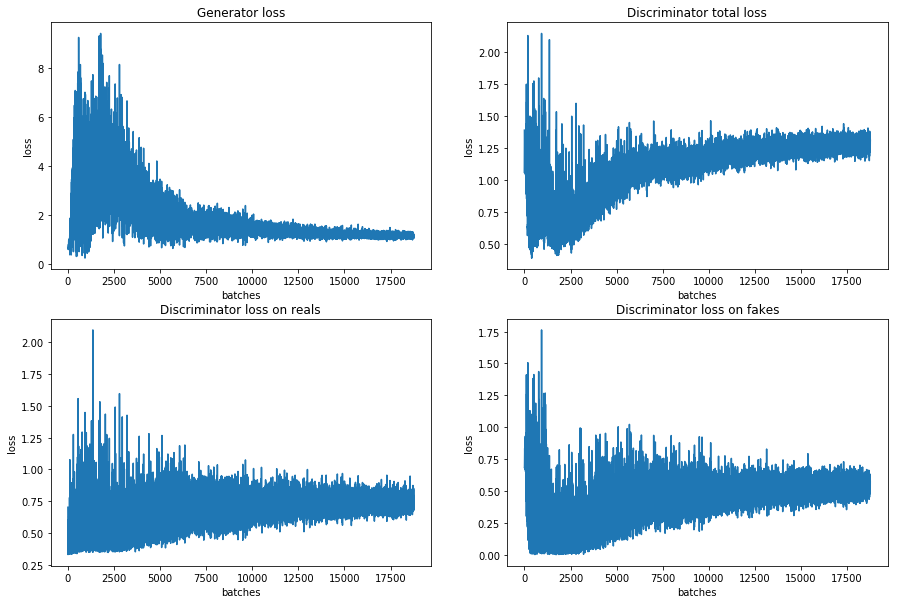

In [17]:
G_initedFC = GeneratorFC(latent_vector_length=100).to(device)
G_initedFC.apply(params_init)

D_initedFC = DiscriminatorFC().to(device)
D_initedFC.apply(params_init)

(imgsFC, G_FC, D_FC) = experiment_MNIST(D_optimizer="Adam", 
                                     D_lr=0.0002, 
                                     D_momentum=None, 
                                     G_optimizer="Adam", 
                                     G_lr=0.0002, 
                                     G_momentum=None, 
                                     epochs=40, 
                                     D=D_initedFC, 
                                     G=G_initedFC, 
                                     train_policy_function=train_alternate_MNIST, 
                                     D_class=DiscriminatorFC, 
                                     G_class=GeneratorFC)

How did the generated images change with training?

10 201


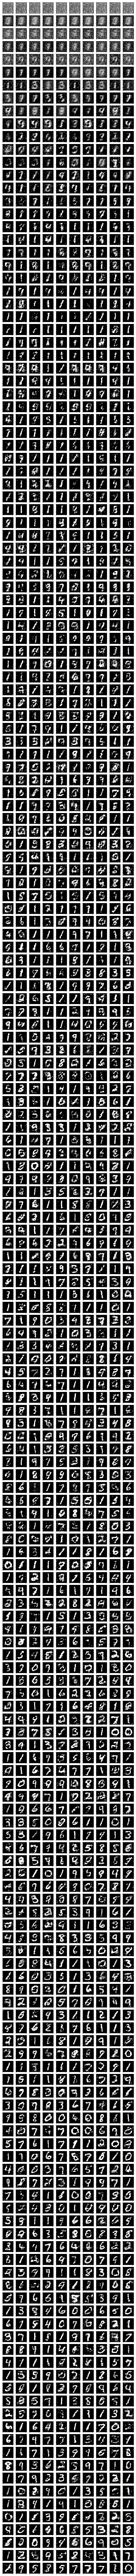

In [18]:
plot_generated_images(imgsFC, num_per_row=10, skip_by=2)

Interpolate linearly between random latent vectors

In [0]:
def interpolate_image(vec1, vec2, num_images, G):
    plt.rcParams["figure.figsize"] = [num_images, 1]
    diff = vec2 - vec1
    
    images = []
    
    plt.subplot(1, num_images, 1)
    images.append(G(vec1.to(device)).detach().cpu().view(28, 28))
    plt.imshow(images[-1], cmap="gray")
    
    for i in range(1, num_images-1):
        delta = diff * (i / (num_images-1))
        images.append(
            G((vec1 + delta).to(device)).detach().cpu().view(28, 28)
        )
        plt.subplot(1, num_images, 1 + i)
        plt.imshow(images[-1], cmap="gray")
    
    images.append(G(vec2.to(device)).detach().cpu().view(28, 28))
    plt.subplot(1, num_images, num_images)
    plt.imshow(images[-1], cmap="gray")
    

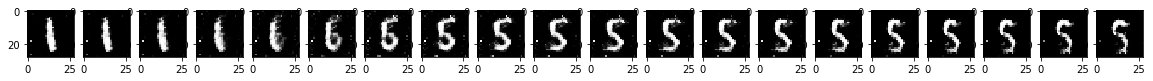

In [20]:
interpolate_image(torch.randn(100), torch.randn(100), 20, G_FC)

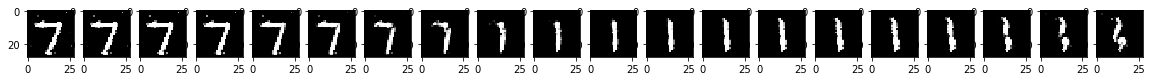

In [38]:
interpolate_image(torch.randn(100), torch.randn(100), 20, G_FC)

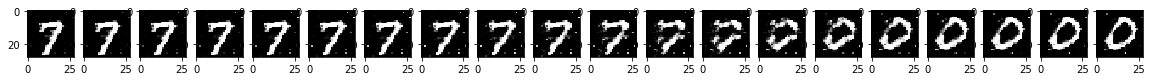

In [32]:
interpolate_image(torch.randn(100), torch.randn(100), 20, G_FC)

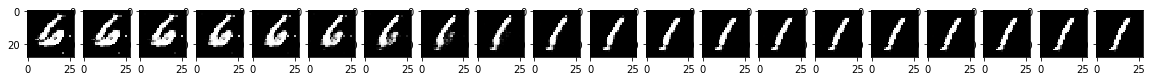

In [35]:
interpolate_image(torch.randn(100), torch.randn(100), 20, G_FC)

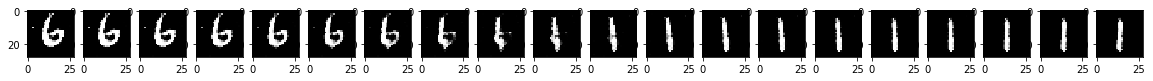

In [51]:
interpolate_image(torch.randn(100), torch.randn(100), 20, G_FC)

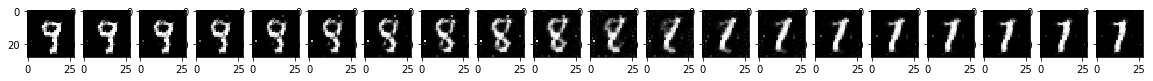

In [67]:
interpolate_image(torch.randn(100), torch.randn(100), 20, G_FC)

Unfortunately I couln't get Conv Discriminator and Transpose Conv Generator to work properly yet